In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import os 
import PIL
import time

2021-11-03 18:14:11.924996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 18:14:11.925095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset_name = 'diabetic_retinopathy_detection/btgraham-300'
subdataset_name = 'btgraham-300'
print(dataset_name)

diabetic_retinopathy_detection/btgraham-300


In [19]:
#dataset, info= tfds.load(dataset_name,split=tfds.Split.TRAIN, download=True, with_info=True)
dataset, info = tfds.load(dataset_name,split=['train', 'test'], download=True, with_info=True)
#dataset = dataset.map(lambda image: tf.image.resize_with_crop_or_pad(image, 64, 64))
print(type(dataset))

<class 'list'>


In [47]:
def dataset_len (ds):
  num_elements = 0
  for elem in ds:
    num_elements += 1
  return num_elements

In [4]:
BATCH_SIZE = 256

In [5]:
IMG_SIZE = 64

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [38]:
batch_size = BATCH_SIZE
AUTOTUNE = tf.data.AUTOTUNE

def reshapeDataset(ds):
  # Resize and rescale all datasets.
  ds_image = ds.map(lambda x: (resize_and_rescale(x['image'])), 
              num_parallel_calls=AUTOTUNE)
  ds_label = ds.map(lambda x: x['label'], num_parallel_calls=AUTOTUNE) 
  return ds_image.prefetch(buffer_size=AUTOTUNE), ds_label.prefetch(buffer_size=AUTOTUNE)

In [7]:
def make_discriminator_model():
  aKernelSize = 5
  aStrides = 2
  dropOutRatio = 0.3

  layersInfo = [(32, 64), (16,128), (8, 256), (4, 512)]
  
  model = tf.keras.Sequential()
  
  layer_0 = layersInfo[0]
  model.add(layers.Conv2D(layer_0[1], kernel_size=aKernelSize, strides=aStrides, padding='same', input_shape=[64, 64, 3], name='dis_1'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_1 = layersInfo[1]
  model.add(layers.Conv2D(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_2'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_2 = layersInfo[2]
  model.add(layers.Conv2D(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_3'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  layer_3 = layersInfo[3]
  model.add(layers.Conv2D(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', name='dis_4'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(dropOutRatio))

  model.add(layers.Flatten())
  model.add(layers.Dense(1)
)

  return model

In [8]:
def make_generator_model():
  aKernelSize = 5
  aStrides = 2
  z_dim = 100

  layersInfo = [(4, 1024), (8, 512), (16,256), (32, 128), (64, 3)]
  
  layer_0 = (4, 1024)
  model = tf.keras.Sequential()
  model.add(layers.Dense(layer_0[0] ** 2 * layer_0[1], use_bias=False, input_shape=(z_dim,), name='gen_1'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  
  model.add(layers.Reshape((layer_0[0], layer_0[0], layer_0[1])))
  print(model.output_shape)
  assert model.output_shape == (None, layer_0[0], layer_0[0], layer_0[1])  # Note: None is the batch size

  layer_1 = layersInfo[1]
  model.add(layers.Conv2DTranspose(layer_1[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_2'))
  print(model.output_shape)
  assert model.output_shape == (None, layer_1[0], layer_1[0], layer_1[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_2 = layersInfo[2]
  model.add(layers.Conv2DTranspose(layer_2[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_3'))
  assert model.output_shape == (None, layer_2[0], layer_2[0], layer_2[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_3 = layersInfo[3]
  model.add(layers.Conv2DTranspose(layer_3[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, name='gen_4'))
  assert model.output_shape == (None, layer_3[0], layer_3[0], layer_3[1])
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  layer_4 = layersInfo[4]
  model.add(layers.Conv2DTranspose(layer_4[1], kernel_size=aKernelSize, strides=aStrides, padding='same', use_bias=False, activation='tanh', name='gen_5'))
  assert model.output_shape == (None, layer_4[0], layer_4[0], layer_4[1])

  return model

In [9]:
generator = make_generator_model()

(None, 4, 4, 1024)
(None, 8, 8, 512)


In [10]:
discriminator = make_discriminator_model()

In [11]:
learing_rate = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(learing_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learing_rate)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

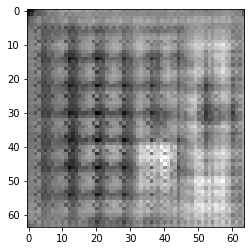

In [28]:
seed = tf.random.normal([16, 100])
generatedImage = generator(seed, training=False)
_ = plt.imshow(generatedImage[0, :, :, 0], cmap='gray')

In [16]:
discriminator_flatten = tf.keras.models.clone_model(discriminator)
discriminator_flatten.set_weights(discriminator.get_weights())
discriminator_flatten.pop()
discriminator_flatten.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dis_1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
dis_2 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
dis_3 (Conv2D)               (None, 8, 8, 256)        

In [50]:
reshape_train_data, reshape_train_label = reshapeDataset(dataset[0])
reshape_test_data, reshape_test_label = reshapeDataset(dataset[1])

In [66]:
new_train_data = reshape_train_data.batch(1).map(lambda x: discriminator_flatten(x, training=False)[0])

In [116]:
for img3 in reshape_train_data.batch(1).take(1):  
  val = discriminator_flatten(img3, training=False)[0]
  print(val)
  print(val.shape)
  #print(discriminator_flatten(img3, training=False)[0])

  #discriminator_flatten()
  #_ = plt.imshow(img2)

tf.Tensor(
[ 1.0571464  -0.37084123 -0.46173054 ... -0.1010403  -0.0361594
  0.16688022], shape=(8192,), dtype=float32)
(8192,)


In [137]:
def build_linear_regression_model (input_shape, optimizerProp=0.001):
  model = tf.keras.Sequential()
  model.add(layers.Dense(1, input_shape=input_shape))
  model.add(layers.Dense(1))

  optimizer = tf.keras.optimizers.RMSprop(optimizerProp)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model
  

In [150]:
model = build_linear_regression_model((8192, 1))


In [155]:
model.fit(new_train_data.take(10))

ValueError: in user code:

    /home/juan/.local/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /home/juan/.local/lib/python3.8/site-packages/keras/engine/training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:622 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /home/juan/.local/lib/python3.8/site-packages/keras/optimizer_v2/utils.py:72 filter_empty_gradients
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['linear_model_1/kernel:0', 'linear_model_1/bias:0'].


In [142]:
example_batch = new_train_data.take(10)
example_result = model.predict(example_batch)
example_result



array([[[ 0.19886398]],

       [[-0.06976039]],

       [[-0.08685794]],

       ...,

       [[-0.01843433]],

       [[-0.00785828]],

       [[ 0.01968666]]], dtype=float32)

In [164]:

for img5 in new_train_data:
  val = tfds.as_numpy(img5)
  val.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [174]:
arr = np.array([])
for elm in new_train_data.take(10):
  np.append(arr, tfds.as_numpy(elm), axis=0)

In [177]:
arr.size

0

In [163]:
ds_as_numpy = new_train_data.map(lambda t: tfds.as_numpy(t))

InvalidArgumentError: in user code:

    /tmp/ipykernel_250126/1618053553.py:1 None  *
        lambda t: tfds.as_numpy(t)
    /home/juan/.local/lib/python3.8/site-packages/tensorflow_datasets/core/api_utils.py:53 disallow_positional_args_dec  **
        return fn(*args, **kwargs)
    /home/juan/.local/lib/python3.8/site-packages/tensorflow_datasets/core/dataset_utils.py:257 as_numpy
        np_arrays = sess.run([tensor for tensor in flat_ds
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:967 run
        result = self._run(None, fetches, feed_dict, options_ptr,
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:1190 _run
        results = self._do_run(handle, final_targets, final_fetches,
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:1368 _do_run
        return self._do_call(_run_fn, feeds, fetches, targets, options,
    /home/juan/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:1394 _do_call
        raise type(e)(node_def, op, message)  # pylint: disable=no-value-for-parameter

    InvalidArgumentError: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [8192]
    	 [[node args_0 (defined at tmp/ipykernel_250126/2775831837.py:1) ]]
    
    Original stack trace for 'args_0':
      File "usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
        return _run_code(code, main_globals, None,
      File "usr/lib/python3.8/runpy.py", line 87, in _run_code
        exec(code, run_globals)
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
        app.launch_new_instance()
      File "home/juan/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
        app.start()
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
        self.io_loop.start()
      File "home/juan/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
        self.asyncio_loop.run_forever()
      File "usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
        self._run_once()
      File "usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
        handle._run()
      File "usr/lib/python3.8/asyncio/events.py", line 81, in _run
        self._context.run(self._callback, *self._args)
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
        await self.process_one()
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
        await dispatch(*args)
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
        await result
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
        reply_content = await reply_content
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
        res = shell.run_cell(code, store_history=store_history, silent=silent)
      File "home/juan/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
        return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
        result = self._run_cell(
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
        return runner(coro)
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
        coro.send(None)
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
        has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
        if (await self.run_code(code, result,  async_=asy)):
      File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
        exec(code_obj, self.user_global_ns, self.user_ns)
      File "tmp/ipykernel_250126/2775831837.py", line 1, in <module>
        ds_as_numpy = new_train_data.map(lambda t: tfds.as_numpy(t))
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1861, in map
        return MapDataset(self, map_func, preserve_cardinality=True)
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4981, in __init__
        self._map_func = StructuredFunctionWrapper(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4218, in __init__
        self._function = fn_factory()
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3150, in get_concrete_function
        graph_function = self._get_concrete_function_garbage_collected(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3116, in _get_concrete_function_garbage_collected
        graph_function, _ = self._maybe_define_function(args, kwargs)
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3463, in _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3298, in _create_graph_function
        func_graph_module.func_graph_from_py_func(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 923, in func_graph_from_py_func
        func_args = _get_defun_inputs_from_args(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1159, in _get_defun_inputs_from_args
        return _get_defun_inputs(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1232, in _get_defun_inputs
        placeholder = graph_placeholder(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/graph_only_ops.py", line 38, in graph_placeholder
        op = g._create_op_internal(  # pylint: disable=protected-access
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 599, in _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3561, in _create_op_internal
        ret = Operation(
      File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
        self._traceback = tf_stack.extract_stack_for_node(self._c_op)
    


Original stack trace for 'args_0':
  File "usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "home/juan/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "home/juan/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
    await result
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "home/juan/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "home/juan/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "tmp/ipykernel_250126/2775831837.py", line 1, in <module>
    ds_as_numpy = new_train_data.map(lambda t: tfds.as_numpy(t))
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1861, in map
    return MapDataset(self, map_func, preserve_cardinality=True)
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4981, in __init__
    self._map_func = StructuredFunctionWrapper(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 4218, in __init__
    self._function = fn_factory()
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3150, in get_concrete_function
    graph_function = self._get_concrete_function_garbage_collected(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3116, in _get_concrete_function_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3463, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/function.py", line 3298, in _create_graph_function
    func_graph_module.func_graph_from_py_func(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 923, in func_graph_from_py_func
    func_args = _get_defun_inputs_from_args(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1159, in _get_defun_inputs_from_args
    return _get_defun_inputs(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 1232, in _get_defun_inputs
    placeholder = graph_placeholder(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/eager/graph_only_ops.py", line 38, in graph_placeholder
    op = g._create_op_internal(  # pylint: disable=protected-access
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py", line 599, in _create_op_internal
    return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3561, in _create_op_internal
    ret = Operation(
  File "home/juan/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [161]:
for img6 in reshape_test_label.take(1):
  print(tfds.as_numpy(img6))

0


In [93]:
example_result.transpose()

array([[[0.04082279, 0.01475418, 0.01837029, ..., 0.00401996,
         0.00143863, 0.00644426]]], dtype=float32)

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])